## Ambient Light Sensor on v3 Flight System Evaluation

Sensor is a VEML3328, which is a RGBCIR sensor. This means it measures red, green, and blue color spectra and additionally measures a 'clear' band (broad band response), and an IR band. 

Begining with basic data import. Data is grabbed from database using `ALSData_Selector.sql`.

Read in Pandas dataframe

#### Units/Preprocessing:
The RGB, Clear, and IR values are read in from the VELM3328. All values are reported in &mu;W/cm^2 - since this is the standard for these type of measures and the conversion factors established are in the form of &mu;W/cm^2. 

The PAR standard data was recorded by an SQ-202X sensor - the voltage reading is converted to &mu;mols m^-2 s^-1 in the SQL parsing.
The solar data was recorded by an SP-421 sensor - the solar radiation data is read directly over SDI-12 and no conversion is needed. Values are reported in W/m^2

#### Data:
Data was reorded over an approximately 10 day period at the St Paul ROC by the logger `GEMS_6`. This logger was setup in a convetnional MET station deployment and had all sensors mounted on the same mast. The logger (v3.1) was mounted in a standard logger box and placed on a horizontal cross bar so that light sensor was parelel to the ground. 

Data was recorded using `v2.8.6` device firmware, and `v1.7.4` Kestrel driver 

In [204]:
import numpy as np
import pandas as pd
# Import data from csv files
TestTT = pd.read_csv('ALSData.csv',parse_dates =["time"], index_col ="time")

TestTT = TestTT.sort_values(by=["time"])
print(TestTT.info())
print(TestTT.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1084 entries, 2023-11-16 00:13:27 to 2023-11-27 23:05:44
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Clear   1084 non-null   float64
 1   Red     1084 non-null   float64
 2   Green   1084 non-null   float64
 3   Blue    1084 non-null   float64
 4   IR      1084 non-null   float64
 5   PAR     1084 non-null   float64
 6   Solar   1084 non-null   float64
dtypes: float64(7)
memory usage: 67.8 KB
None
                        Clear       Red     Green      Blue        IR     PAR  \
time                                                                            
2023-11-16 00:13:27  0.024397  0.003811  0.012821  0.016544  0.000625  0.0000   
2023-11-16 00:28:37  0.035636  0.005716  0.014022  0.005055  0.001250  0.0000   
2023-11-16 00:43:44  0.010965  0.007622  0.027644  0.017923  0.001250  0.0000   
2023-11-16 00:58:51  0.032072  0.009527  0.032051  0.015625  0.001250  0.0

### Find Best Estimation of PAR and Solar from ALS Data
We need to determine the best method of estimating PAR and solar radiation data. Since the spectral responses between the sensor standards and the ALS sensor - we need to find a combination of bands which best fits the ground truth data.

To do this we take the sum of all channels available (clear, red, green, blue, IR) and then multiple them with an array of a binary sequence. This will test all possible permutations of summation of the 5 bands and determine which combination has the best R^2 value.

The optimal configuration of each is printed out after conclusion of the testing.

---

*Note: This evaluation currently ignores the subtractive combinations of bands. This is left for future analysis*

In [199]:
#Create binary sequence to use for exhaustive test
vals = np.array([range(1, 32)], dtype=np.uint8).transpose()
bins = np.unpackbits(vals, axis = 1, bitorder='little')

#Find optimal combination for PAR
R2Max = 0
iMax = bins[0]
for i in bins:
    model = TestTTHour['Clear']*i[0] + TestTTHour['Red']*i[1] + TestTTHour['Green']*i[2] + TestTTHour['Blue']*i[3] + TestTTHour['IR']*i[4] #Appoximation to test
    control = TestTTHour['PAR'] #Ground truth 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(model, control)
#     print("R^2\t=\t",i,'\t',r_value**2)
    if r_value**2 > R2Max:
        R2Max = r_value**2
        iMax = i
print("PAR Results:")
print("\tR^2, Max = ",R2Max)
print("\tChannel Config: ", iMax)

#Find optimal combination for Solar
R2Max = 0
iMax = bins[0]
for i in bins:
    model = TestTTHour['Clear']*i[0] + TestTTHour['Red']*i[1] + TestTTHour['Green']*i[2] + TestTTHour['Blue']*i[3] + TestTTHour['IR']*i[4] #Appoximation to test
    control = TestTTHour['Solar'] #Ground truth 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(model, control)
#     print("R^2\t=\t",i,'\t',r_value**2)
    if r_value**2 > R2Max:
        R2Max = r_value**2
        iMax = i
print("Solar Results:")
print("\tR^2, Max = ",R2Max)
print("\tChannel Config: ", iMax)

PAR Results:
	R^2, Max =  0.9930862577570202
	Channel Config:  [1 0 0 0 0 0 0 0]
Solar Results:
	R^2, Max =  0.9885384908056202
	Channel Config:  [1 0 0 0 1 0 0 0]


### Estimation Results
The best combination of bands for PAR is simply the `Clear` band alone. This makes sense since this will give the best correlation with the range of frequencies in question with a solar black body source.

The best combination of bands for solar radiation is found to be `Clear` plus `IR`. This makes sense since the response of the solar radiation sensor (as opposed to the PAR range, which is only 400nm to 700nm) extends into the long wavelength IR range - 400nm to 1000nm.

---

Based on these results, we apply the approriate conversion to the chanels in question, along with scaling them to minimize the mean error. We then determine the goodness of fit using standard means and report the conversion factors. A simple set of comparison plots as well as error plots are made for a randomly selected (selected by human with no particular motivation) subset of the data in order to visualize the fit.

### Determine and Apply Conversion Factor

PAR Cal Value:  0.11142748830654767
Solar Cal Value:  0.12492673355015314

PAR Model Stats:
	RMSE =	 22.072762571815346
	MAE =	 9.13065860007404
	ME =	 4.115467912927292e-14
	R^2 = 	 0.99308625775702

Solar Model Stats:
	RMSE =	 23.665695788395798
	MAE =	 10.148165961110227
	ME =	 -1.204643541554942e-13
	R^2 = 	 0.9885384908056202


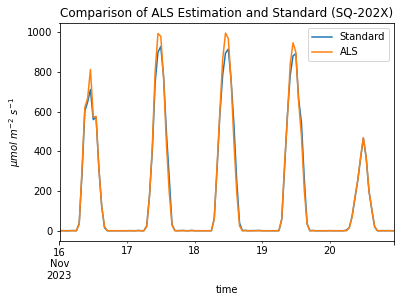

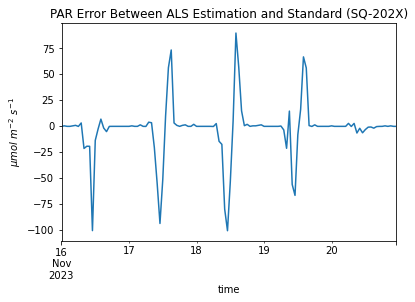

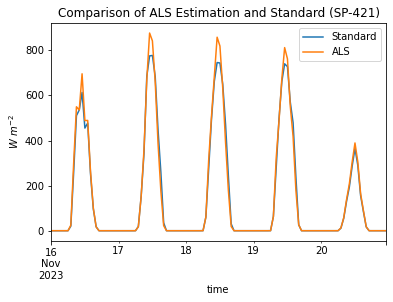

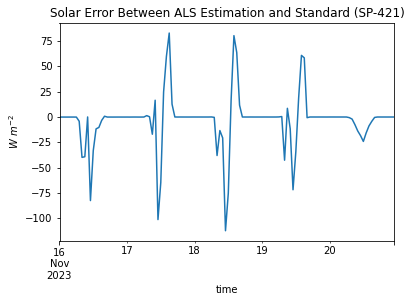

In [207]:
import matplotlib.pyplot as plt

#Calculate conversion factors
calSolar = np.mean(TestTTHour['Solar'])/np.mean((TestTTHour['Clear'] + TestTTHour['IR'])/2)
calPAR = np.mean(TestTTHour['PAR'])/np.mean(TestTTHour['Clear'])
#Apply conversion factors
TestTTHour['PAR_Model'] = TestTTHour['Clear']*calPAR 
TestTTHour['Solar_Model'] = ((TestTTHour['Clear'] + TestTTHour['IR'])/2)*calSolar 
#Calculate error from conversion
TestTTHour['PAR_Error'] = TestTTHour['PAR'] - TestTTHour['PAR_Model']
TestTTHour['Solar_Error'] = TestTTHour['Solar'] - TestTTHour['Solar_Model']

print("PAR Cal Value: ", calPAR)
print("Solar Cal Value: ", calSolar)

testPlot = TestTTHour.loc['2023-11-14':'2023-11-20'] #Plot for reduced range to see detail

#Evaluate resulting PAR model
print("\nPAR Model Stats:")
print("\tRMSE =\t", np.sqrt(np.mean((TestTTHour['PAR_Error'])**2))) #RMSE
print("\tMAE =\t", np.mean(np.abs(TestTTHour['PAR_Error']))) #MAE
print("\tME =\t", np.mean((TestTTHour['PAR_Error']))) #ME
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(TestTTHour['PAR_Model'], TestTTHour['PAR'])
print("\tR^2 = \t", r_value**2) #R^2

#Print subset example
parCompPlot = testPlot.plot(y = ['PAR','PAR_Model'], ylabel = "$\mu mol\ m^{-2}\ s^{-1}$", title="Comparison of ALS Estimation and Standard (SQ-202X)") 
parCompPlot.legend(["Standard","ALS"])
parCompPlot.figure.savefig('PARCompare.pdf', dpi = 300,bbox_inches='tight')
parErrorPlot = testPlot.plot(y = 'PAR_Error', ylabel = "$\mu mol\ m^{-2}\ s^{-1}$", title="PAR Error Between ALS Estimation and Standard (SQ-202X)", legend=False)
parCompPlot.figure.savefig('PARError.pdf', dpi = 300,bbox_inches='tight')

#Evaluate resulting Solar model
print("\nSolar Model Stats:")
print("\tRMSE =\t", np.sqrt(np.mean((TestTTHour['Solar_Error'])**2))) #RMSE
print("\tMAE =\t", np.mean(np.abs(TestTTHour['Solar_Error']))) #MAE
print("\tME =\t", np.mean((TestTTHour['Solar_Error']))) #ME
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(TestTTHour['Solar_Model'], TestTTHour['Solar'])
print("\tR^2 = \t", r_value**2) #R^2

#Print subset example
solarCompPlot = testPlot.plot(y = ['Solar','Solar_Model'], ylabel = "$W\ m^{-2}$", title="Comparison of ALS Estimation and Standard (SP-421)")
solarCompPlot.legend(["Standard","ALS"])
solarCompPlot.figure.savefig('SolarCompare.pdf', dpi = 300,bbox_inches='tight')
solarErrorPlot = testPlot.plot(y = 'Solar_Error', ylabel = "$W\ m^{-2}$", title="Solar Error Between ALS Estimation and Standard (SP-421)", legend=False)
# solarErrorPlot.legend(["Error"])
# solarErrorPlot.title(["Error Between ALS Estimation and Standard"])
solarErrorPlot.figure.savefig('SolarError.pdf', dpi = 300,bbox_inches='tight')


### Fit Analysis
The results of the fit are very good. In addition to the high R^2 already observed, the mean error is extremely small. This is to be expected since the values were scaled to minimize this error - this error is effectively zero. 

However, even the MAE is less than 1% of the expected range. 

It should also be noted how tightly the fit is correlated with the expected results. Take the solar radiation conversion for example. The conversion factor from $mu;W/cm^2 to W/m^2 is a factor of 10x. This means that if all bands matched up exactly, we would expect the conversion factor for the ALS value to be 0.1. Instead the conversion factor is 0.125. This indicates that the response is about 25\% less than expected. This perfectly aligns with the transmitivity of polycarbonate (which is the top material of the logger box). The transmitvity in the visable spectrum is about 85\%, but reduces in the IR range. Having a average transmitivity of 75\% is therefore perfectly reasonable. 

### Regression Plots
Lastly we generate a set of regression plots to show the correlation between the estimated values and the results from the measurment standard.

As with the results seen from the basic statistics the fit looks very good and has no decernable dependance on amplitude. The only observable characteristic is an increased deviation with amplitude - this is expected from the sensor uncertianty itself. 

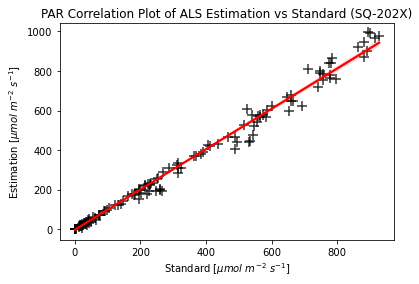

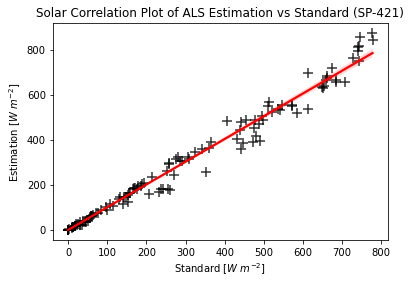

In [208]:
import seaborn as sns
gfg_PAR = sns.regplot(x='PAR',y='PAR_Model',data=TestTTHour,fit_reg=True, color="0", marker='+', line_kws=dict(color="r"), scatter_kws={'s':100})
gfg_PAR.set(xlabel = "Standard [$\mu mol\ m^{-2}\ s^{-1}$]", ylabel = "Estimation [$\mu mol\ m^{-2}\ s^{-1}$]", title="PAR Correlation Plot of ALS Estimation vs Standard (SQ-202X)")
plt.show()
gfg_Solar = sns.regplot(x='Solar',y='Solar_Model',data=TestTTHour,fit_reg=True, color="0", marker='+', line_kws=dict(color="r"), scatter_kws={'s':100})
gfg_Solar.set(xlabel = "Standard [$W\ m^{-2}$]", ylabel = "Estimation [$W\ m^{-2}$]", title="Solar Correlation Plot of ALS Estimation vs Standard (SP-421)")
plt.show()